# 基于RNN和决策树的多因子选股策略 

## Part1·使用RNN预测股票走势


### 本代码将实现以下几个目标
* 比较两种流行RNN：LSTM和GRU在预测股票走势上的优劣
* 比较网络结构在预测股票走势上的优劣
* 最终效果最好的模型将作为我们选股策略中预测股票走势的模型

#### 高宜琛 1701214047 2018.06.24

### 1. 数据爬取：
首先, 我们最终选择的股票为15年至今有完整记录的股票，共计3547支股票，其中90%的数据作为训练集，其余为测试集，来测试不同模型的预测能力。不同的是，在回测时，我们使用2015-01-01至2017-12-31期间的股价数据作为训练集，2018-01-01至今的数据作为测试集，来验证我们的收益率。

这一步的输入为我们从Bigquant网站上下载的股票序号csv文件，其格式为一个3548\*1的表格，第1行为表头“StockIndex”，其余行为股票代码，内容为：**股票代码.SZA/SHA**，其中“SZA”表示深证A股，“SHA”表示沪证A股，如深证A股“平安银行”对应的csv项为：**000001.SZA**，上证A股“浦发银行”对应的csv项为：**600000.SHA**。生成该CSV代码为**BQ0_indicesExport.ipynb**：

``
ins=D.instruments(start_date='2015-01-01', end_date='2018-06-24', market='CN_STOCK_A')
print('共计'+str(len(ins))+'支股票')
stockIndices={"StockIndex" : ins}#先将ins转换为字典，方便存储
stockIndices=pd.DataFrame(stockIndices)#将字典转换成为数据框
stockIndices.to_csv('stockIndices.csv')
``

该步的输出为pandas包中定义的dataframe，主要内容为上述时间段内，各支股票每天的开盘价(open)、收盘价(close)、最高价(hight)和最低价(low)，其他类似成交量(volume)、价格变动(p_change)等特征本实验没有使用。数据获取采用tushare库。为了方便比较，我们将每支股票的数据存储为单独的csv文件，文件名为:**股票代码.csv**，方便之后训练时使用。

**要安装tushare，请依次执行:**

``
pip install lxml
pip install requests
pip install bs4
pip install tushare
pip install tushare --upgrade
``

In [4]:
import tushare as ts # TuShare is a utility for crawling historical data of China stocks
import pandas as pd
import numpy as np

print(ts.__version__)

1.1.7


In [5]:
df = pd.read_csv('stockIndices.csv')
print(df.head())
print(len(df))

start_date = '2015-01-01'
end_date = '2018-06-24'

   StockIndex
0  000001.SZA
1  000002.SZA
2  000004.SZA
3  000005.SZA
4  000006.SZA
3547


生成训练数据，保存在**当前目录./stockData** 文件夹下，初次运行需要**新建文件夹**。爬取数据相对耗时，但只需要执行一次

由于新浪接口会限制ip访问次数，导致tushare库在持续爬取数据时可能产生 _HTTPError:456_ 的错误，因此下面Cell中的代码段中加入了异常处理。如果遇到代码不能执行的情况，**请使用BigQuant版本的代码“BQ1_fetchData.ipynb”来获取数据**

In [ ]:
cnt=1
errorList=[]
for index in df['StockIndex']:
    stock=index[0:index.find('.')]# 获取纯数字的股票编号
    csv_name = './stockData/{}.csv'.format(stock)# 定义要存储csv文件名
    try:
        df2 = ts.get_k_data(code=stock, start=start_date,end=end_date, autype=None)# 获取股票的日线数据
    except Exception as e:
        errorList.append(int(stock))
        print('%s error! Sleeping...' % (index))
        time.sleep(120)
    else:
        df2 = df2.reset_index(drop=True)
        col_list=['open','high','low','volume','close']
        df2 = df2[col_list]
        df2['volume'] = df2['volume'] / 1000000 #数据预处理
        df2.to_csv(csv_name, index=False) #保存数据
        print('%s done! %d/%d, %.2f%%' % (index,cnt,len(df),float(cnt)/len(df)*100))
        cnt+=1
np.savetxt("./errorResult.txt",errorList,fmt='%d')

### 2. 数据准备

**需要安装keras库，运行 _pip install keras_ 即可**

In [13]:
import numpy as np
import pandas as pd
import time
import math
import keras as ks

import sklearn.preprocessing as prep
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2" #防止使用掉所有的GPU

** 定义两个数据预处理函数 **
* ** _standard_scaler_ 用来将数据减去均值后再除以方差 **
* ** _preprocess_data_ 用来划分数据集，并且生成可以输入RNN的序列 **
* 由于Tushare和BigQuant得到的数据顺序相反，所以定义两个不同的处理函数

In [14]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [15]:
def preprocess_data_BQ(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [16]:
def preprocess_data_JN(stock, seq_len):
    # 反向，与BQ唯一的不同
    stock=stock[:: -1] 
    
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]    

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

### 3. 构建RNN网络

* 模型1.1

    _**LSTM** --> Dropout --> **LSTM** --> Dropout --> Fully-Conneted(Dense)_
    
* 模型1.2

    _**LSTM** --> **LSTM** --> Fully-Conneted(Dense) --> Fully-Conneted(Dense)_
    
* 模型1.3

    _**LSTM** --> Dropout --> **LSTM** --> Dropout --> Fully-Conneted(Dense) --> Fully-Conneted(Dense)_
    
    
* 模型2.1

    _**GRU** --> Dropout --> **GRU** --> Dropout --> Fully-Conneted(Dense)_
    
* 模型2.2

    _**GRU** --> **GRU** --> Fully-Conneted(Dense) --> Fully-Conneted(Dense)_
    
* 模型2.3

    _**GRU** --> Dropout --> **GRU** --> Dropout --> Fully-Conneted(Dense) --> Fully-Conneted(Dense)_

In [33]:
def build_model_11(layers):
    model = ks.models.Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(ks.layers.LSTM(
        input_shape=(layers[1],layers[0]),
        units=layers[1],
        return_sequences=True))
    model.add(ks.layers.Dropout(0.4))

    model.add(ks.layers.LSTM(
        units=layers[2],
        return_sequences=False))
    model.add(ks.layers.Dropout(0.3))

    model.add(ks.layers.Dense(
        units=layers[3]))
    model.add(ks.layers.Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [34]:
def build_model_12(layers):
    model = ks.models.Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(ks.layers.LSTM(
        input_shape=(layers[1],layers[0]),
        units=layers[1],
        return_sequences=True))

    model.add(ks.layers.LSTM(
        units=layers[2],
        return_sequences=False))

    model.add(ks.layers.Dense(
        units=layers[3]))
    model.add(ks.layers.Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [35]:
def build_model_13(layers):
    model = ks.models.Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(ks.layers.LSTM(
        input_shape=(layers[1],layers[0]),
        units=layers[1],
        return_sequences=True))
    model.add(ks.layers.Dropout(0.4))

    model.add(ks.layers.LSTM(
        units=layers[2],
        return_sequences=False))
    model.add(ks.layers.Dropout(0.3))

    model.add(ks.layers.Dense(
        units=layers[3]))
    model.add(ks.layers.Activation("linear"))

    model.add(ks.layers.Dense(
        units=layers[4]))
    model.add(ks.layers.Activation("linear"))
    
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [48]:
def build_model_21(layers):
    model = ks.models.Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(ks.layers.GRU(
        input_shape=(layers[1],layers[0]),
        units=layers[1],
        return_sequences=True))
    model.add(ks.layers.Dropout(0.4))

    model.add(ks.layers.GRU(
        units=layers[2],
        return_sequences=False))
    model.add(ks.layers.Dropout(0.3))

    model.add(ks.layers.Dense(
        units=layers[3]))
    model.add(ks.layers.Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [49]:
def build_model_22(layers):
    model = ks.models.Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(ks.layers.GRU(
        input_shape=(layers[1],layers[0]),
        units=layers[1],
        return_sequences=True))

    model.add(ks.layers.GRU(
        units=layers[2],
        return_sequences=False))

    model.add(ks.layers.Dense(
        units=layers[3]))
    model.add(ks.layers.Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [50]:
def build_model_23(layers):
    model = ks.models.Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(ks.layers.GRU(
        input_shape=(layers[1],layers[0]),
        units=layers[1],
        return_sequences=True))
    model.add(ks.layers.Dropout(0.4))

    model.add(ks.layers.GRU(
        units=layers[2],
        return_sequences=False))
    model.add(ks.layers.Dropout(0.3))

    model.add(ks.layers.Dense(
        units=layers[3]))
    model.add(ks.layers.Activation("linear"))

    model.add(ks.layers.Dense(
        units=layers[4]))
    model.add(ks.layers.Activation("linear"))
    
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [51]:
window = 20
model_11 = build_model_11([X_train.shape[2], window, 100, 1])
model_12 = build_model_12([X_train.shape[2], window, 100, 1])
model_13 = build_model_13([X_train.shape[2], window, 100, 100, 1])
model_21 = build_model_21([X_train.shape[2], window, 100, 1])
model_22 = build_model_22([X_train.shape[2], window, 100, 1])
model_23 = build_model_23([X_train.shape[2], window, 100, 100, 1])

Compilation Time :  0.022846221923828125
Compilation Time :  0.022412776947021484
Compilation Time :  0.024495363235473633
Compilation Time :  0.024022340774536133
Compilation Time :  0.022249460220336914
Compilation Time :  0.020292043685913086


### 4. 开始训练

In [ ]:
cnt=1
validCSV=len(df)
trainMSE_11=0
testMSE_11=0
trainMSE_12=0
testMSE_12=0
trainMSE_13=0
testMSE_13=0
trainMSE_21=0
testMSE_21=0
trainMSE_22=0
testMSE_22=0
trainMSE_23=0
testMSE_23=0

for index in df['StockIndex']:
    stock=index[0:index.find('.')]# 获取纯数字的股票编号
    csv_name = './stockData/{}.csv'.format(stock)# 定义要读取的csv文件名
    try:
        df2 = pd.read_csv(csv_name)
    except Exception as e:
        validCSV-=1
        print('%s doesn\'t exist, already skipped' %(index))
    else:
        df2 = df2.reset_index(drop=True)
        col_list=['open','high','low','volume','close']
        df2 = df2[col_list]
        # 根据数据来源自行选择，程序附带数据为BigQuant下载得到
        X_train, y_train, X_test, y_test = preprocess_data_BQ(df2[::], window)
        # 如果使用Tushare下载数据，则使用下面的函数
        # X_train, y_train, X_test, y_test = preprocess_data_JN(df2[::], window)
        model_11.fit(
            X_train,
            y_train,
            batch_size=128,
            epochs=10,
            validation_split=0.1,
            verbose=0)
        trainScore = model_11.evaluate(X_train, y_train, verbose=0)
        trainMSE_11+=trainScore[0]
        testScore = model_11.evaluate(X_test, y_test, verbose=0)
        testMSE_11+=testScore[0]
        
        model_12.fit(
            X_train,
            y_train,
            batch_size=128,
            epochs=10,
            validation_split=0.1,
            verbose=0)
        trainScore = model_12.evaluate(X_train, y_train, verbose=0)
        trainMSE_12+=trainScore[0]
        testScore = model_12.evaluate(X_test, y_test, verbose=0)
        testMSE_12+=testScore[0]
        
        model_13.fit(
            X_train,
            y_train,
            batch_size=128,
            epochs=10,
            validation_split=0.1,
            verbose=0)
        trainScore = model_13.evaluate(X_train, y_train, verbose=0)
        trainMSE_13+=trainScore[0]
        testScore = model_13.evaluate(X_test, y_test, verbose=0)
        testMSE_13+=testScore[0]
        
        model_21.fit(
            X_train,
            y_train,
            batch_size=128,
            epochs=10,
            validation_split=0.1,
            verbose=0)
        trainScore = model_21.evaluate(X_train, y_train, verbose=0)
        trainMSE_21+=trainScore[0]
        testScore = model_21.evaluate(X_test, y_test, verbose=0)
        testMSE_21+=testScore[0]
        model_21.fit(
            X_train,
            y_train,
            batch_size=128,
            epochs=10,
            validation_split=0.1,
            verbose=0)
        trainScore = model_21.evaluate(X_train, y_train, verbose=0)
        trainMSE_21+=trainScore[0]
        testScore = model_21.evaluate(X_test, y_test, verbose=0)
        testMSE_21+=testScore[0]
        
        model_22.fit(
            X_train,
            y_train,
            batch_size=128,
            epochs=10,
            validation_split=0.1,
            verbose=0)
        trainScore = model_22.evaluate(X_train, y_train, verbose=0)
        trainMSE_22+=trainScore[0]
        testScore = model_22.evaluate(X_test, y_test, verbose=0)
        testMSE_22+=testScore[0]
        
        model_23.fit(
            X_train,
            y_train,
            batch_size=128,
            epochs=10,
            validation_split=0.1,
            verbose=0)
        trainScore = model_23.evaluate(X_train, y_train, verbose=0)
        trainMSE_23+=trainScore[0]
        testScore = model_23.evaluate(X_test, y_test, verbose=0)
        testMSE_23+=testScore[0]
        print('%d\\%d' %(cnt,validCSV))
        cnt+=1


In [ ]:
trainMSE_11/=validCSV
trainMSE_12/=validCSV
trainMSE_13/=validCSV
trainMSE_21/=validCSV
trainMSE_22/=validCSV
trainMSE_23/=validCSV

testMSE_11/=validCSV
testMSE_12/=validCSV
testMSE_13/=validCSV
testMSE_21/=validCSV
testMSE_22/=validCSV
testMSE_23/=validCSV

print('Model_11 Train Score: %.2f MSE (%.2f RMSE)' % (trainMSE_11, math.sqrt(trainMSE_11)))
print('Model_12 Train Score: %.2f MSE (%.2f RMSE)' % (trainMSE_12, math.sqrt(trainMSE_12)))
print('Model_13 Train Score: %.2f MSE (%.2f RMSE)' % (trainMSE_13, math.sqrt(trainMSE_13)))
print('Model_21 Train Score: %.2f MSE (%.2f RMSE)' % (trainMSE_21, math.sqrt(trainMSE_21)))
print('Model_22 Train Score: %.2f MSE (%.2f RMSE)' % (trainMSE_22, math.sqrt(trainMSE_22)))
print('Model_23 Train Score: %.2f MSE (%.2f RMSE)' % (trainMSE_23, math.sqrt(trainMSE_23)))

由于完成全部股票训练时间较长，下面的代码段用来**在一个指定股票数据上训练**，仅供调试用

In [66]:
trainMSE_11=0
testMSE_11=0
trainMSE_12=0
testMSE_12=0
trainMSE_13=0
testMSE_13=0
trainMSE_21=0
testMSE_21=0
trainMSE_22=0
testMSE_22=0
trainMSE_23=0
testMSE_23=0
csv_name = './stockData/{}.csv'.format('000001')# 定义要读取的csv文件名
try:
    df2 = pd.read_csv(csv_name)
except Exception as e:
    print('%s doesn\'t exist, already skipped' %(csv_name))
else:
    df2 = df2.reset_index(drop=True)
    col_list=['open','high','low','volume','close']
    df2 = df2[col_list]
    window = 20
    
    # 根据数据来源自行选择，程序附带数据为BigQuant下载得到
    X_train, y_train, X_test, y_test = preprocess_data_BQ(df2[::], window)
    # 如果使用Tushare下载数据，则使用下面的函数
#     X_train, y_train, X_test, y_test = preprocess_data_JN(df2[::], window)
    print('Training...')
    model_11.fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=300,
        validation_split=0.1,
        verbose=0)
    trainScore = model_11.evaluate(X_train, y_train, verbose=0)
    trainMSE_11+=trainScore[0]
    testScore = model_11.evaluate(X_test, y_test, verbose=0)
    testMSE_11+=testScore[0]

    model_12.fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=300,
        validation_split=0.1,
        verbose=0)
    trainScore = model_12.evaluate(X_train, y_train, verbose=0)
    trainMSE_12+=trainScore[0]
    testScore = model_12.evaluate(X_test, y_test, verbose=0)
    testMSE_12+=testScore[0]

    model_13.fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=300,
        validation_split=0.1,
        verbose=0)
    trainScore = model_13.evaluate(X_train, y_train, verbose=0)
    trainMSE_13+=trainScore[0]
    testScore = model_13.evaluate(X_test, y_test, verbose=0)
    testMSE_13+=testScore[0]

    model_21.fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=300,
        validation_split=0.1,
        verbose=0)
    trainScore = model_21.evaluate(X_train, y_train, verbose=0)
    trainMSE_21+=trainScore[0]
    testScore = model_21.evaluate(X_test, y_test, verbose=0)
    testMSE_21+=testScore[0]
    model_21.fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=300,
        validation_split=0.1,
        verbose=0)
    trainScore = model_21.evaluate(X_train, y_train, verbose=0)
    trainMSE_21+=trainScore[0]
    testScore = model_21.evaluate(X_test, y_test, verbose=0)
    testMSE_21+=testScore[0]

    model_22.fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=300,
        validation_split=0.1,
        verbose=0)
    trainScore = model_22.evaluate(X_train, y_train, verbose=0)
    trainMSE_22+=trainScore[0]
    testScore = model_22.evaluate(X_test, y_test, verbose=0)
    testMSE_22+=testScore[0]

    model_23.fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=300,
        validation_split=0.1,
        verbose=0)
    trainScore = model_23.evaluate(X_train, y_train, verbose=0)
    trainMSE_23+=trainScore[0]
    testScore = model_23.evaluate(X_test, y_test, verbose=0)
    testMSE_23+=testScore[0]
    print('Model_11 Train Score: %.2f MSE (%.2f RMSE)' % (trainMSE_11, math.sqrt(trainMSE_11)))
    print('Model_12 Train Score: %.2f MSE (%.2f RMSE)' % (trainMSE_12, math.sqrt(trainMSE_12)))
    print('Model_13 Train Score: %.2f MSE (%.2f RMSE)' % (trainMSE_13, math.sqrt(trainMSE_13)))
    print('Model_21 Train Score: %.2f MSE (%.2f RMSE)' % (trainMSE_21, math.sqrt(trainMSE_21)))
    print('Model_22 Train Score: %.2f MSE (%.2f RMSE)' % (trainMSE_22, math.sqrt(trainMSE_22)))
    print('Model_23 Train Score: %.2f MSE (%.2f RMSE)' % (trainMSE_23, math.sqrt(trainMSE_23)))    

3547
        open       high        low    volume  close
0  15.990000  16.280001  15.599999  0.000286  16.02
1  15.849999  16.389999  15.550000  0.000217  15.78
2  15.560001  15.830000  15.300000  0.000170  15.48
3  15.500000  15.570000  14.900001  0.000141  14.96
4  14.900001  15.870001  14.709999  0.000251  15.08
        open       high        low    volume  close
0  15.990000  16.280001  15.599999  0.000286  16.02
1  15.849999  16.389999  15.550000  0.000217  15.78
2  15.560001  15.830000  15.300000  0.000170  15.48
3  15.500000  15.570000  14.900001  0.000141  14.96
4  14.900001  15.870001  14.709999  0.000251  15.08
10\3547
Model_11 Train Score: 0.23 MSE (0.48 RMSE)
Model_12 Train Score: 0.13 MSE (0.37 RMSE)
Model_13 Train Score: 0.23 MSE (0.48 RMSE)
Model_21 Train Score: 1.06 MSE (1.03 RMSE)
Model_22 Train Score: 0.20 MSE (0.45 RMSE)
Model_23 Train Score: 0.65 MSE (0.81 RMSE)


### 5. 使用模型预测并可视化

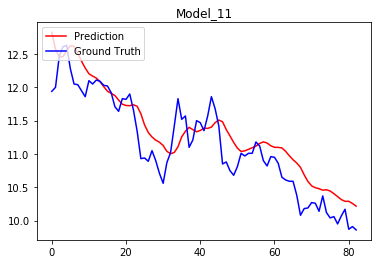

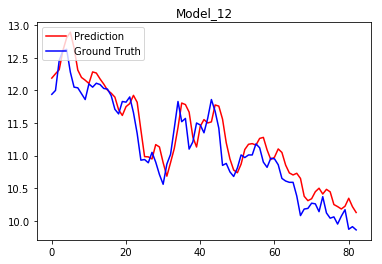

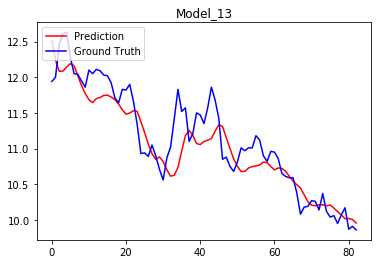

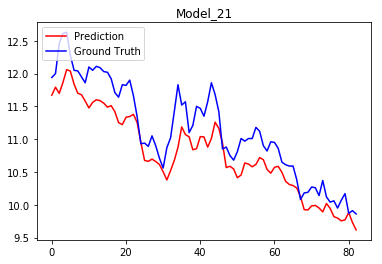

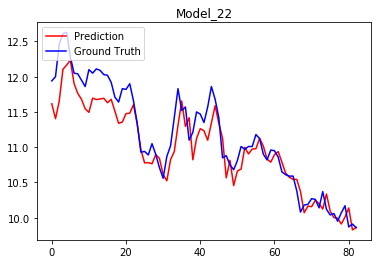

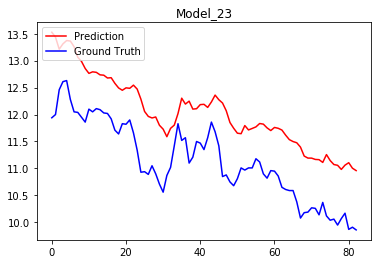

In [75]:
import matplotlib.pyplot as plt2
csv_name = './stockData/{}.csv'.format('000001')# 定义要读取的csv文件名
try:
    df2 = pd.read_csv(csv_name)
except Exception as e:
    print('%s doesn\'t exist, already skipped' %(csv_name))
else:
    df2 = df2.reset_index(drop=True)
    col_list=['open','high','low','volume','close']
    df2 = df2[col_list]
    window = 20
    
    # 根据数据来源自行选择，程序附带数据为BigQuant下载得到
    X_train, y_train, X_test, y_test = preprocess_data_BQ(df2[::], window)
    diff = []
    ratio = []
    pred = model_11.predict(X_test)
    for u in range(len(y_test)):
        pr = pred[u][0]
        ratio.append((y_test[u] / pr) - 1)
        diff.append(abs(y_test[u] - pr))

    plt2.figure(1)
    plt2.plot(pred, color='red', label='Prediction')
    plt2.plot(y_test, color='blue', label='Ground Truth')
    plt2.legend(loc='upper left')
    plt2.title('Model_11')
    plt2.savefig("prediction_11.jpg")
    plt2.show()

    diff = []
    ratio = []
    pred = model_12.predict(X_test)
    for u in range(len(y_test)):
        pr = pred[u][0]
        ratio.append((y_test[u] / pr) - 1)
        diff.append(abs(y_test[u] - pr))

    plt2.figure(2)
    plt2.plot(pred, color='red', label='Prediction')
    plt2.plot(y_test, color='blue', label='Ground Truth')
    plt2.legend(loc='upper left')
    plt2.title('Model_12')
    plt2.savefig("prediction_12.jpg")
    plt2.show()

    diff = []
    ratio = []
    pred = model_13.predict(X_test)
    for u in range(len(y_test)):
        pr = pred[u][0]
        ratio.append((y_test[u] / pr) - 1)
        diff.append(abs(y_test[u] - pr))

    plt2.figure(3)
    plt2.plot(pred, color='red', label='Prediction')
    plt2.plot(y_test, color='blue', label='Ground Truth')
    plt2.legend(loc='upper left')
    plt2.title('Model_13')
    plt2.savefig("prediction_13.jpg")
    plt2.show()

    diff = []
    ratio = []
    pred = model_21.predict(X_test)
    for u in range(len(y_test)):
        pr = pred[u][0]
        ratio.append((y_test[u] / pr) - 1)
        diff.append(abs(y_test[u] - pr))

    plt2.figure(4)
    plt2.plot(pred, color='red', label='Prediction')
    plt2.plot(y_test, color='blue', label='Ground Truth')
    plt2.legend(loc='upper left')
    plt2.title('Model_21')
    plt2.savefig("prediction_21.jpg")
    plt2.show()

    diff = []
    ratio = []
    pred = model_22.predict(X_test)
    for u in range(len(y_test)):
        pr = pred[u][0]
        ratio.append((y_test[u] / pr) - 1)
        diff.append(abs(y_test[u] - pr))

    plt2.figure(5)
    plt2.plot(pred, color='red', label='Prediction')
    plt2.plot(y_test, color='blue', label='Ground Truth')
    plt2.legend(loc='upper left')
    plt2.title('Model_22')
    plt2.savefig("prediction_22.jpg")
    plt2.show()

    diff = []
    ratio = []
    pred = model_23.predict(X_test)
    for u in range(len(y_test)):
        pr = pred[u][0]
        ratio.append((y_test[u] / pr) - 1)
        diff.append(abs(y_test[u] - pr))

    plt2.figure(6)
    plt2.plot(pred, color='red', label='Prediction')
    plt2.plot(y_test, color='blue', label='Ground Truth')
    plt2.legend(loc='upper left')
    plt2.title('Model_23')
    plt2.savefig("prediction_23.jpg")
    plt2.show()